In [ ]:
#COLAB
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Device: cuda
Content image size:  1680 1050
Processing size:  1024 640
Input image has NO alpha channel: required for added functionality
Mask size: (128, 80)


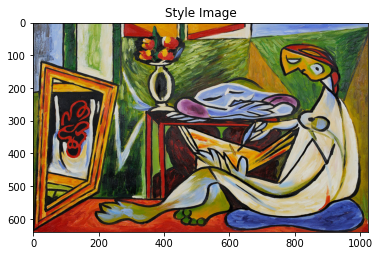

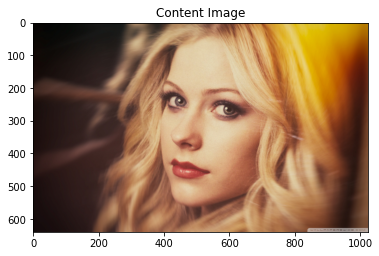

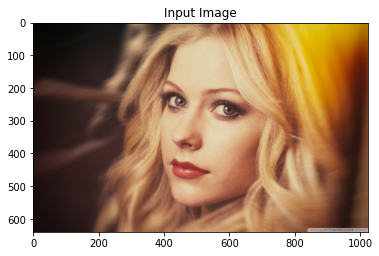

Building style transfer model..
conv1_1 Style MSE loss
conv2_1 Style SL1 loss
conv3_1 Style SL1 loss
conv4_1 Style SL1 loss
conv4_2 Content MSE loss
conv5_1 Style SL1 loss
Sequential(
  (0): Normalization()
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_MSE1_1): StyleLoss()
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool1_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_SL12_1): StyleLoss()
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_SL13_1): StyleLoss()
  (relu3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:301: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:302: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


run [50]:
Style Loss : 2.498744 Content Loss: 3.690580


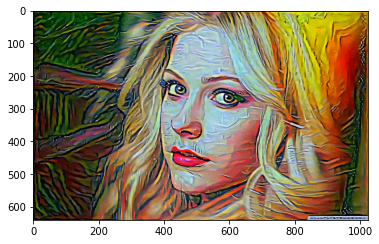


run [100]:
Style Loss : 1.225584 Content Loss: 2.705894


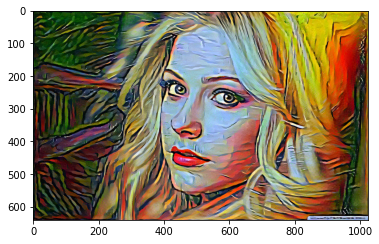


VERSION: v01
ITERATION: 0002
Style transfer complete 



In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb  7 11:19:22 2020

@author: jonthum

STYLE TRANSFER

INM705 Coursework
by Jon Thum

"""

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)



#VERSIONING
VERSION = '_v01'      #Program version
ITERATION = '_0001'   #Parameters version

#PARAMETERS
EPOCHS = 100         #Number of epochs
SIZE = 1024          #Image output width (keeping content aspect ratio)

#IMAGES
STYLE =   'la_muse.jpg'                            #Style image
CONTENT = 'avril.jpg'                          #Content image
INPUT =   'avril.jpg'                          #Input image
OUTPUT =  'INM705' + VERSION + ITERATION + '.jpg' #Output image

#INPUT NOISE              #Adds abstraction to output
FG_NOISE = 0.0            #Foreground noise using mask 0->1
BG_NOISE = 0.0            #Background noise using mask 0->1
NOISE_RANGE = 1           #Noise range 0->1
#RGBA image: foreground has FG_NOISE, background has BG_NOISE
#RGB image: linear mix of input with BG_NOISE (FG_NOISE is ignored)

#STYLE LAYERS AND WEIGHTS
GLOBAL_STYLE_WEIGHT = 1e6                   #Global style weight
STYLE_WEIGHTS = [1, 1, 1, 1, 1]             #Relative style weights layers 1->5 e.g.[1.5, 1, 0.5, 0.5, 0.5]
STYLE_LAYERS_MSE = ['conv1_1']              #MSE loss layers
STYLE_LAYERS_SL1 = ['conv2_1','conv3_1','conv4_1','conv5_1'] #SL1 loss layers

#STYLE TILING                               #Adds detail to output
TILE = 1                                    #For no tiling, TILE = 1

#CONTENT LAYERS AND WEIGHTS                 #Use FG_CONTENT_WEIGHT to reduce(>1) or increase(<1) abstraction
FG_CONTENT_WEIGHT = 5                     #Additional content weight through mask
GLOBAL_CONTENT_WEIGHT = 1                   #Global content weight
CONTENT_WEIGHTS = [1]                       #Relative content weights    
CONTENT_LAYERS = ['conv4_2']                #With MSE loss default

#POOLING
AVE_POOLING = True                          #MAX POOLING best, AVE_POOLING fast

#CNN MODEL   
cnn = models.vgg19(pretrained=True).features.to(device).eval()    


#PLOTS
PARAMETERS = 'Parameters' + VERSION + ITERATION + '.jpg'
STYLE_LOSS = 'Style_loss' + VERSION + ITERATION + '.jpg'
CONTENT_LOSS = 'Content_loss' + VERSION + ITERATION + '.jpg'

#DIRECTORIES
root_dir = '/content/gdrive/My Drive/AiPainter/'
style_name = root_dir + 'images/style/' + STYLE
content_name = root_dir + 'images/content/' + CONTENT
input_name = root_dir + 'images/content/' + INPUT
output_name = root_dir + 'images/results/' + OUTPUT
parameters_name = root_dir + 'images/plots/' + PARAMETERS
style_loss_name = root_dir + 'images/plots/' + STYLE_LOSS
content_loss_name = root_dir + 'images/plots/' + CONTENT_LOSS

#FIX RANDOMNESS FOR CONSISTENCY
SEED = 999
np.random.seed(SEED)  


#GET DESIRED ASPECT RATIO FROM CONTENT IMAGE

image = Image.open(content_name)
aspect = image.size[0]/image.size[1]
IM_SIZE = (SIZE, int(SIZE/aspect))

print("Content image size: ", image.size[0], image.size[1])
print("Processing size: ", IM_SIZE[0], IM_SIZE[1])


#TILING FOR STYLE IMAGE

def image_tile(image, tile):
    width = image.size[0]
    height = image.size[1]

    #Tile size
    x = int(width/tile)
    y = int(height/tile)

    #Calculate step size for (step x step) grid
    step = int(tile+0.999) 
    step = step - step%2 + 1

    #Calculate offset
    offx = int((step-tile)*x/2)
    offy = int((step-tile)*y/2)

    #Make bigger image
    new = Image.new('RGB', [width+offx, height+offy])

    #Resize and flipflop if necessary
    im = image.resize([x, y], Image.BICUBIC)
    if(int(((step+1)/2)%2)==0):
        im = im.transpose(Image.ROTATE_180)
    
    #Make tiled grid
    py = 0
    for j in range(step):
        px = 0
        imx = im
        for i in range(step):
            new.paste (imx, [px, py])
            imx = imx.transpose(Image.FLIP_LEFT_RIGHT)
            px += x
        py += y  
        im = im.transpose(Image.FLIP_TOP_BOTTOM)

    #Crop back to original size
    new = new.crop((offx, offy, width+offx, height+offy))

    return new


#ADD NOISE TO INPUT IMAGE IF REQUIRED

def noise_mix(image):
    #Generate noise
    noise = np.random.rand(image.size[1], image.size[0], 3)
    noise = 256*((noise-0.5)*NOISE_RANGE + 0.5)
    noise = noise.astype(int)
    noise = Image.fromarray(np.uint8(noise)) 

    #If image is'RGB' do linear mix with noise (amount BG_NOISE)
    if(len(image.getbands())==3):
        comp = Image.blend(image, noise, BG_NOISE)
        mask = Image.new('L', image.size)
        print("Input image has NO alpha channel: required for added functionality")

    #If image is 'RGBA' composite noise using alpha channel (amounts FG_NOISE/BG_NOISE)                   
    elif(len(image.getbands())==4):
        mask = image.getchannel('A')
        image = image.convert('RGB')
        bg_mix = Image.blend(image, noise, BG_NOISE)  
        fg_mix = Image.blend(image, noise, FG_NOISE)
        comp = Image.composite(fg_mix, bg_mix, mask) 
    else:
        print("Input image needs to be either RGB or RGBA")

    return comp, mask


#IMAGE LOADING

def image_loader(image_name, style_tile=1, input_image=False, content_image=False):
    image = Image.open(image_name)

    #INPUT IMAGE
    if(input_image):
      image, mask = noise_mix(image)        #Add noise if required

      #MASK FOR CONTENT LAYER
      mask = mask.resize(IM_SIZE)
      layer = int(CONTENT_LAYERS[0][4])     #Get level of content layer 
      for i in range(layer-1):              #Reduce by half for (layer-1) pooling levels
        width = int(mask.size[0]/2)
        height = int(mask.size[1]/2)
        mask = mask.resize([width,height])  #Resized mask 
      print('Mask size:', mask.size)

    #CONTENT IMAGE
    if(content_image):
      image = image.convert('RGB')          #Strip out alpha channel

    #RESIZE INPUT AND CONTENT
    image = image.resize(IM_SIZE)           #Set processing size

    #STYLE IMAGE
    if(style_tile != 1):
      image = image_tile(image, style_tile)   #Tile style image 

    #TRANSFORM TO TENSORS
    loader = transforms.ToTensor()
    image = loader(image).unsqueeze(0)

    if(input_image):
      mask = loader(mask).unsqueeze(0)
      return image.to(device, torch.float), mask.to(device, torch.float)
    else:
      return image.to(device, torch.float)


#IMAGE DISPLAY

unloader = transforms.ToPILImage()  #Reconvert into PIL image

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  #Clone the tensor to not do changes on it
    image = image.squeeze(0)      #Remove the fake batch dimension
    
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)              #Pause so that plots are updated


#IMAGE SAVE

def imsave(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)     
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    image = image.save(output_name)
    

#CONTENT LOSS

class ContentLoss(nn.Module):

    def __init__(self, target, mask):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

        #ADJUST CONTENT WEIGHTS FOR FOREGROUND THROUGH MASK
        self.mask = mask*(FG_CONTENT_WEIGHT-1) + 1
        
    def forward(self, input):
        loss = F.mse_loss(input, self.target, reduction='none')
        loss = torch.mul(loss, self.mask)     #Multiply pixel losses by mask
        self.loss = torch.mean(loss) 
        return input


#GRAM MATRIX   

def gram_matrix(input):
    a, b, c, d = input.size()  
    features = input.view(a * b, c * d) 

    G = torch.mm(features, features.t())  
    return G.div(a * b * c * d)


#STYLE LOSS

class StyleLoss(nn.Module):

    def __init__(self, target_feature, loss_function):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss_function = loss_function

    def forward(self, input):
        G = gram_matrix(input)
        #SMOOTH_L1 
        if(self.loss_function=='SL1'):
          self.loss = F.smooth_l1_loss(G, self.target)
        #MEAN SQUARED ERROR  
        elif(self.loss_function=='MSE'):
          self.loss = F.mse_loss(G, self.target)
        else:
          print('Style Loss undefined')
        return input


#NORMALISATION

#NETWORK TRAINED WITH THESE VALUES    
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

#NORMALISE INPUT IMAGE
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std


#BUILD MODEL WITH ACCESS TO LAYERS FOR STYLE AND CONTENT LOSS

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img, mask,
                               content_layers=CONTENT_LAYERS,
                               style_layers1=STYLE_LAYERS_SL1,
                               style_layers2=STYLE_LAYERS_MSE):
    cnn = copy.deepcopy(cnn)

    #NORMALISATION MODULE
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    #SEQUENTIAL MODEL
    model = nn.Sequential(normalization)

    i = 0  #Increment for each conv layer
    j = 1  #Increment for each level
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv{}_{}'.format(j, i)

        elif isinstance(layer, nn.ReLU):
            name = 'relu{}_{}'.format(j, i)         
            layer = nn.ReLU(inplace=False)

        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool{}_{}'.format(j, i)
            j += 1
            i = 0

        #OPTIONAL AVERAGE POOLING
            if (AVE_POOLING):
                layer = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)

        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn{}_{}'.format(j, i)
  
        model.add_module(name, layer)

        #DIFFERENT LOSS FUNCTIONS
        if name in content_layers:
            #CONTENT LOSS = MSE:
            target = model(content_img).detach()
            content_loss = ContentLoss(target, mask)
            model.add_module("content_loss_MSE{}_{}".format(j, i), content_loss)
            content_losses.append(content_loss)
            print(name, 'Content MSE loss')

        if name in style_layers1:
            #STYLE LOSS = SL1:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature, 'SL1')
            model.add_module("style_loss_SL1{}_{}".format(j, i), style_loss)
            style_losses.append(style_loss)
            print(name, 'Style SL1 loss')

        if name in style_layers2:
            #STYLE LOSS = MSE:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature, 'MSE')
            model.add_module("style_loss_MSE{}_{}".format(j, i), style_loss)
            style_losses.append(style_loss)
            print(name, 'Style MSE loss')

    #TRIM REMAINING LAYERS
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    print(model)

    return model, style_losses, content_losses


#GRADIENT DESCENT

def get_input_optimizer(input_img):
    #optimizer = optim.Adam([input_img.requires_grad_()], lr=1e-2, weight_decay = 1e-3)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    return optimizer


#NEURAL TRANSFER

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, mask, num_steps=EPOCHS,
                       global_style_weight=GLOBAL_STYLE_WEIGHT, content_weight=1,
                       style_weights=STYLE_WEIGHTS, content_weights=CONTENT_WEIGHTS):
  
    print('Building style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img, mask)
    optimizer = get_input_optimizer(input_img)

    style_plots = []
    content_plots = []

    print('Optimizing..')
    run = [0]
    while run[0] < num_steps:

    #EVALUATE MODEL AND RETURN LOSS
        def eval():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)

            style_score = 0
            content_score = 0
            style_plot = []
            content_plot = []

            #MULTIPLY LOSSES BY RELATIVE WEIGHTS
            for i, sl in enumerate(style_losses):
                loss = sl.loss*style_weights[i]
                style_score += loss
                style_plot.append(loss)
            style_plots.append(style_plot)

            for i, cl in enumerate(content_losses):
                loss = cl.loss*content_weights[i]
                content_score += loss
                content_plot.append(loss)
            content_plots.append(content_plot)

            #MULTIPLY LOSSESS BY GLOBAL WEIGHTS
            style_score *= global_style_weight
            content_score *= content_weight
  
            #TOTAL LOSS
            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                imshow(input_img)
                print()

            return style_score + content_score

        optimizer.step(eval)

    #NEED TO MAKE SURE VALUES STAY IN RANGE
    input_img.data.clamp_(0, 1)

    return input_img, style_plots, content_plots


#GET INPUTS

content_img = image_loader(content_name, content_image=True)
style_img = image_loader(style_name, style_tile=TILE)
input_img, mask = image_loader(input_name, input_image=True)

#SHOW INPUTS
plt.ion()
plt.figure()
imshow(style_img, title='Style Image')
plt.figure()
imshow(content_img, title='Content Image')    
plt.figure()
imshow(input_img, title='Input Image')

#RUN ALGORITHM

output, style_plots, content_plots  = run_style_transfer(cnn, cnn_normalization_mean, 
                            cnn_normalization_std, content_img, style_img, input_img, mask)

print('VERSION: {}'.format(VERSION[1:]))
print('ITERATION: {}'.format(ITERATION[1:]))
print('Style transfer complete \n')



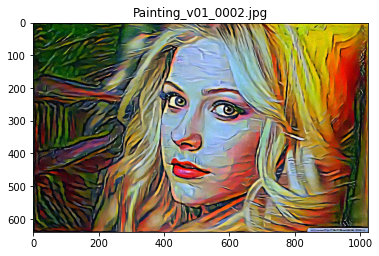

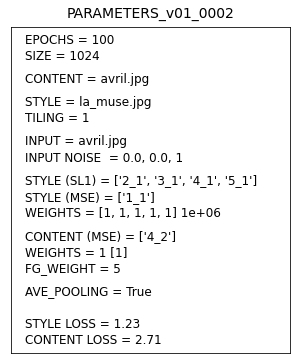

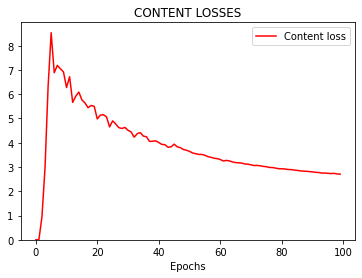

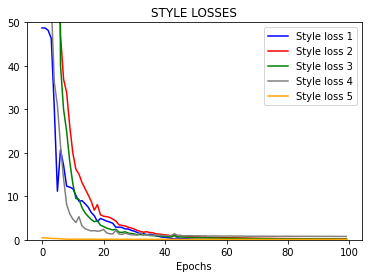

In [ ]:


#SAVE IMAGE
imsave(output, title=OUTPUT)  

#SAVE PARAMETERS 

#TRUNCATE CONV LAYER NAMES 
style_layers_SL1 = []
style_layers_MSE = []
content_layers = []
for i, layer in enumerate(STYLE_LAYERS_SL1):
  style_layers_SL1.append(layer[4:])
for i, layer in enumerate(STYLE_LAYERS_MSE):
  style_layers_MSE.append(layer[4:])
for i, layer in enumerate(CONTENT_LAYERS):
  content_layers.append(layer[4:])

#LOSSES
style_loss_plot = np.array(style_plots)*GLOBAL_STYLE_WEIGHT
style_loss = style_loss_plot[-1,0:1] + style_loss_plot[-1,1:2] + style_loss_plot[-1,2:3] \
            + style_loss_plot[-1,3:4] + style_loss_plot[-1,4:5] 
content_loss = content_plots[-1]

#PARAMETER REPORT
plt.figure(figsize=(5,6))
plt.xticks([])
plt.yticks([])
plt.text(0.20, 1.03,'PARAMETERS{}{}'.format(VERSION, ITERATION), fontsize=14)
plt.text(0.05, 0.95,'EPOCHS = {}'.format(EPOCHS), fontsize=12)
plt.text(0.05, 0.90,'SIZE = {}'.format(SIZE), fontsize=12)
plt.text(0.05, 0.83,'CONTENT = {}'.format(CONTENT), fontsize=12)
plt.text(0.05, 0.76,'STYLE = {}'.format(STYLE), fontsize=12)
plt.text(0.05, 0.71,'TILING = {}'.format(TILE), fontsize=12)
plt.text(0.05, 0.64,'INPUT = {}'.format(INPUT), fontsize=12)
plt.text(0.05, 0.59,'INPUT NOISE  = {}, {}, {}'.format(FG_NOISE, BG_NOISE, NOISE_RANGE), fontsize=12)
plt.text(0.05, 0.52,'STYLE (SL1) = {}'.format(style_layers_SL1), fontsize=12)
plt.text(0.05, 0.47,'STYLE (MSE) = {}'.format(style_layers_MSE), fontsize=12)
plt.text(0.05, 0.42,'WEIGHTS = {} {:.0e}'.format(STYLE_WEIGHTS, GLOBAL_STYLE_WEIGHT), fontsize=12)
plt.text(0.05, 0.35,'CONTENT (MSE) = {}'.format(content_layers), fontsize=12)
plt.text(0.05, 0.30,'WEIGHTS = {} {}'.format(GLOBAL_CONTENT_WEIGHT, CONTENT_WEIGHTS), fontsize=12)
plt.text(0.05, 0.25,'FG_WEIGHT = {}'.format(FG_CONTENT_WEIGHT), fontsize=12)
plt.text(0.05, 0.18,'AVE_POOLING = {}'.format(AVE_POOLING), fontsize=12)
plt.text(0.05, 0.08,'STYLE LOSS = {:.2f}'.format(style_loss[0]), fontsize=12)
plt.text(0.05, 0.03,'CONTENT LOSS = {:.2f}'.format(content_loss[0]), fontsize=12)
plt.savefig(parameters_name)
plt.show()


#SAVE LOSS PLOTS

#CONTENT LOSS PLOT
plt.plot(content_plots, 'red')
plt.legend( ['Content loss'], loc = 'upper right')
plt.xlabel('Epochs')
plt.title('CONTENT LOSSES')
plt.axis([None, None, 0, None])
plt.savefig(content_loss_name)
plt.show()


#STYLE LOSS PLOTS
plt.plot(style_loss_plot[:,0:1], 'blue')
plt.plot(style_loss_plot[:,1:2], 'red')
plt.plot(style_loss_plot[:,2:3], 'green')
plt.plot(style_loss_plot[:,3:4], 'gray')
plt.plot(style_loss_plot[:,4:5], 'orange')
plt.legend( ['Style loss 1', 'Style loss 2', 'Style loss 3', 'Style loss 4', 'Style loss 5'], loc = 'upper right')
plt.xlabel('Epochs')
plt.title('STYLE LOSSES')
max_y = 5e-5*GLOBAL_STYLE_WEIGHT
plt.axis([None, None, 0, max_y])
plt.savefig(style_loss_name)
plt.show()



